# 프로젝트 : 폐렴 진단기 성능개선

# Step 1. 실험환경 Set-up

### 패키지(라이브러리)들을 import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

앞으로 필요한 변수들을 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 25


BATCH_SIZE를 16에서 32로 변경해서 진행해 보았다.

# Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개  
개수 비는 89%, 10.7%, 0.3%  
val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져오기 위해  
train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train은 4185개, test는 624개, val은 1047개

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 보기

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다.  
파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


tf.data 인스턴스를 만들기  
tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해준다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


이미지에는 라벨 데이터가 따로 없음.  
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들기

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성  
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보기  
decode_img 함수와 process_path 함수를 만든다  
process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경  
get_label을 이용해서 라벨 값을 가져온다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만들기  
num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리  

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인  
train_ds.take(1)은 하나의 데이터만 가져온다는 의미

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test 데이터셋도 만들고, 데이터 개수도 확인

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.  
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환 시키기  
shuffle()을 사용하며 고정 크기 버퍼를 유지,해당 버퍼에서 무작위로 균일하게 다음 요소를 선택  
repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 자동으로 데이터를 맞춰준다.  
batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.  
prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에,  
첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

 좌우 반전 정도의 augmentatio를 도입

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출  
추출된 배치를 image와 label 데이터 셋으로 나누고,  
show_batch() 함수를 이용해서 결과 사진을 본다.

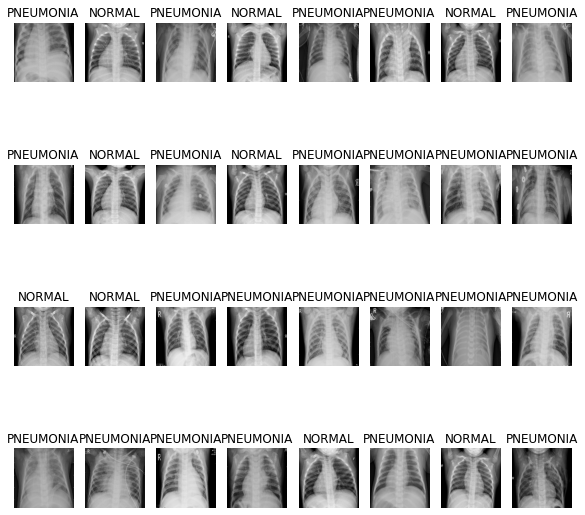

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

아래의 좌우 반전 되기 전의 사진과 비교하여 차이점 비교해 볼 수 있다
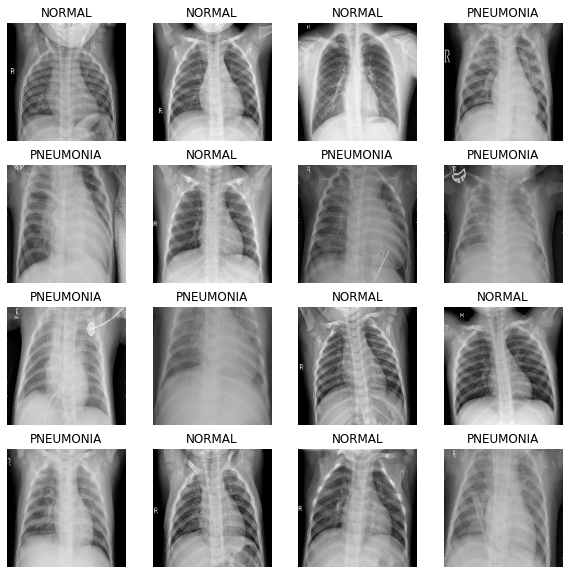

# Step 4. CNN 모델링

이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보기

먼저, Convolution block을 만든다  

conv_block()의 구성은   
Convolution을 두 번 진행하고,   
Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한 후,  
Max Pooling을 진행한다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

Dense Block을 만든다.

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

모델을 생성  
Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용한 특이한 모델.  
(일반적으로 이런 방법은 잘 사용되지 않거나, 금기시됨)

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었음  
한 라벨이 너무 많은 경우를 imbalance 하다고 함  
데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있음  

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용  
training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법  
Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원

weight_for_0은 'Normal' 이미지에 사용할 weight를,  
weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅  
weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

이미지 훈련은 GPU를 사용  
모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언    
이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용  
optimizer로 'adam'을 사용  
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

### 모델을 fit 해보기

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 85s 374ms/step - loss: 0.4222 - accuracy: 0.7870 - precision: 0.9496 - recall: 0.7540 - val_loss: 0.5995 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 375ms/step - loss: 0.2374 - accuracy: 0.8983 - precision: 0.9697 - recall: 0.8908 - val_loss: 0.8180 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 50s 384ms/step - loss: 0.1928 - accuracy: 0.9312 - precision: 0.9773 - recall: 0.9294 - val_loss: 0.9788 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 51s 391ms/step - loss: 0.1824 - accuracy: 0.9320 - precision: 0.9779 - recall: 0.9295 - val_loss: 1.3535 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 55s 426ms/step - loss: 0.1478 - accura

# Step 7. 결과 확인과 시각화

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인하기

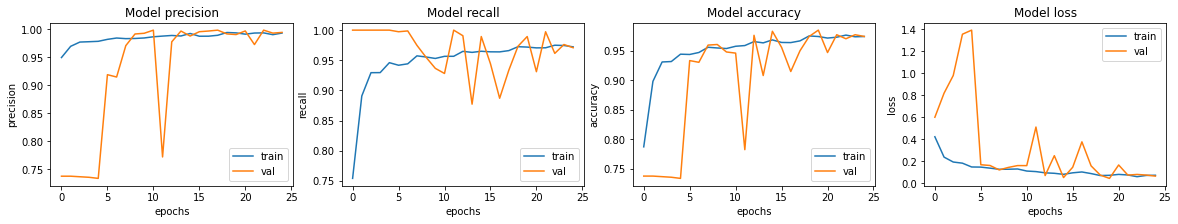

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가 해보기  
모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 209ms/step - loss: 0.5902 - accuracy: 0.8446 - precision: 0.8071 - recall: 0.9872
Loss: 0.5902144312858582,
Accuracy: 0.8445512652397156,
Precision: 0.8071278929710388,
Recall: 0.9871794581413269


# Step 8. 회고

IBM이 만든 인공지능인 왓슨을 기사로만 접해봤는데, 직접 이와 유사한 폐렴 진단기를 직접 만들어 보는 경험을 해 보았다.
내가 만든 것보다 훨씬 정교하겠지만, 어떤 원리로 만들어졌는지 이해하는데 많은 도움이 되었다.

LMS 공부를 통한  성능 개선 방법으로,

Data augmentation 방법과
(이미지 회전, 가우시안 노이즈 추가 방법 (장기의 크기는 사람마다 거의 바뀌지 않는 특성을 이용한 방법))
GAN을 이용해서 Data augmentation을 시도하는 연구에 대해 소개한 것을 보았다.

따라서 성능 개선을 위해
좌우 반전 정도의 augmentation을 도입하였고,
BATCH_SIZE 를 계속 변경을 통해 16을 적용해 보았다.

성능 개선 전에는 아래와 같은 결과가 나왔고,
Loss: 0.7068795561790466,
Accuracy: 0.8669871687889099,
Precision: 0.8434004187583923,
Recall: 0.9666666388511658

성능 개선 후에는 아래와 같은 결과가 나왔다.
Loss: 0.5902144312858582,
Accuracy: 0.8445512652397156,
Precision: 0.8071278929710388,
Recall: 0.9871794581413269

결과적으로 성능개선을 했지만 정확도가 오히려 감소하였고, 리콜값은 높아졌다.

또한,
Batch Normalization, Dropout 를 둘 다 사용했을 때가 하나만 사용 했을 때보다 성능이 좋은지는
오류가 계속 나서 확인하지 못하였다. 다음에 이부분에 관해 계속 연구해 볼 생각이다.